In [1]:
# --- INITIAL SETUP ---

# Core libraries
import os
import pandas as pd
import numpy as np

# NLP and text utilities (for later)
import re
import nltk
from tqdm import tqdm

# Visualization (for later stages)
import matplotlib.pyplot as plt
import seaborn as sns

# Display settings
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.max_columns', None)

# Path to the dataset (update if your structure changes)
data_dir = '/Users/daniel/Northwestern Local/MSDS-422/Final Project - Midpoint/maildir'

# Quick check: how many subfolders and files
num_folders = len(next(os.walk(data_dir))[1])
num_files = sum([len(files) for r, d, files in os.walk(data_dir)])

print(f"Data directory: {data_dir}")
print(f"Total folders (users): {num_folders}")
print(f"Total files (emails): {num_files:,}")

Data directory: /Users/daniel/Northwestern Local/MSDS-422/Final Project - Midpoint/maildir
Total folders (users): 150
Total files (emails): 517,551


In [3]:
import random

# --- SAMPLE A FEW EMAIL FILES TO INSPECT STRUCTURE ---

# Collect a list of all file paths in the dataset
all_email_paths = []
for root, dirs, files in os.walk(data_dir):
    for file in files:
        all_email_paths.append(os.path.join(root, file))

print(f"Total email files found: {len(all_email_paths):,}")

# Randomly select 5 sample emails to inspect
sample_paths = random.sample(all_email_paths, 5)

# Read and print the first 20 lines of each sample email
for path in sample_paths:
    print(f"\n--- SAMPLE EMAIL: {path} ---\n")
    try:
        with open(path, 'r', encoding='latin-1') as f:
            lines = f.readlines()
            print(''.join(lines[:20]))  # print first 20 lines only
    except Exception as e:
        print(f"Error reading {path}: {e}")

Total email files found: 517,551

--- SAMPLE EMAIL: /Users/daniel/Northwestern Local/MSDS-422/Final Project - Midpoint/maildir/hain-m/_sent_mail/250. ---

Message-ID: <27984368.1075860477193.JavaMail.evans@thyme>
Date: Mon, 22 Jan 2001 01:33:00 -0800 (PST)
From: mary.hain@enron.com
To: james.steffes@enron.com
Subject: Re: RTO West Meeting of January 12
Cc: sean.crandall@enron.com, alan.comnes@enron.com, steve.walton@enron.com, 
	tim.belden@enron.com, paul.kaufman@enron.com
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
Bcc: sean.crandall@enron.com, alan.comnes@enron.com, steve.walton@enron.com, 
	tim.belden@enron.com, paul.kaufman@enron.com
X-From: Mary Hain
X-To: James D Steffes
X-cc: Sean Crandall, Alan Comnes, Steve Walton, Tim Belden, Paul Kaufman
X-bcc: 
X-Folder: \Mary_Hain_Aug2000_Jul2001\Notes Folders\'sent mail
X-Origin: Hain-M
X-FileName: mary-hain.nsf



--- SAMPLE EMAIL: /Users/daniel/Northwestern Local/MSDS-422/Final Project - 

In [5]:
import email
from email import policy
from email.parser import BytesParser

# --- PARSE A SUBSET OF EMAILS INTO STRUCTURED FIELDS ---

parsed_data = []
sample_size = 10000  # small for testing
subset_paths = random.sample(all_email_paths, sample_size)

for path in tqdm(subset_paths, desc="Parsing emails"):
    try:
        with open(path, 'rb') as f:
            msg = BytesParser(policy=policy.default).parse(f)
            
            # Extract key headers
            msg_id = msg['Message-ID']
            date = msg['Date']
            sender = msg['From']
            recipient = msg['To']
            subject = msg['Subject']
            
            # Extract message body
            body = ""
            if msg.is_multipart():
                for part in msg.walk():
                    if part.get_content_type() == 'text/plain':
                        body += part.get_content()
            else:
                body = msg.get_content()
            
            parsed_data.append({
                'message_id': msg_id,
                'date': date,
                'from': sender,
                'to': recipient,
                'subject': subject,
                'body': body
            })
    except Exception as e:
        continue  # skip any unreadable emails

# Convert to DataFrame
df = pd.DataFrame(parsed_data)
print(f"Parsed {len(df)} emails successfully.")
df.head(5)

Parsing emails: 100%|████████████████████| 10000/10000 [00:10<00:00, 909.56it/s]

Parsed 10000 emails successfully.


,message_id,date,from,to,subject,body
0,<25477160.1075842681953.JavaMail.evans@thyme>,"Thu, 20 Jul 2000 08:40:00 -0700",gerald.nemec@enron.com,scott.monson@enron.com,TransEnergie CA,"Scott, Attached is the TransEnergie agreement with my revisions. Please \nreview and let me know if you have any questions. If you want executable \ncopies, let me know. Thanks.\n"
1,<25172022.1075853221538.JavaMail.evans@thyme>,"Thu, 24 May 2001 03:30:00 -0700",robert.williams@enron.com,"rgibbs@gibbs-bruns.com, richard.sanders@enron.com",FW: Final Letter!!! CA residential customers,"Per our call.\n\n -----Original Message-----\nFrom: Sharp, Vicki \nSent: Thursday, May 24, 2001 10:22 AM\nTo: Mahoney, Peggy; Williams, Robert C.\nCc: Delainey, David; Dietrich, Janet; Leff, Dan..."
2,<27971275.1075861326712.JavaMail.evans@thyme>,"Mon, 26 Nov 2001 12:52:05 -0800",bryant@cheatsheets.net,cheatsheets@yahoogroups.com,[Footballguys] BREAKING NEWS - Jason Brookins OUT,"From CBS Sportsline: Brookins may miss the rest of the season with a\nbroken foot. Moe Williams will probably become Baltimore's No. 1 RB now, and\nthe Ravens may add another RB to their roster ..."
3,<8550354.1075842037210.JavaMail.evans@thyme>,"Mon, 02 Oct 2000 09:00:00 -0700",liz.taylor@enron.com,None,"Mtg. w/David Port, Ted Murphy & Rudy Zipter - RAC (Demo on Software) - EB 2893 (In Port's office)",Rita Hennesey 33075\nAcey (Rudi Zipter's office)
4,<1269290.1075845194657.JavaMail.evans@thyme>,"Thu, 07 Jun 2001 07:28:44 -0700",kdrouet@molecularelectronics.com,"diserens.stephen@enron.com, mosley.w.@enron.com, trulove.william@enron.com, jr..walter@enron.com, coffee.stan@enron.com, jr..ripley@enron.com, daugbjerg.ray@enron.com, mcspadden.patrick@enron.com,...",Email test,\n\n - Kirwin Drouet.vcf


In [7]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download NLTK resources 
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_email_text(text):
    if not isinstance(text, str):
        return ""
    
    # Remove line breaks and reply markers
    text = re.sub(r'(\r\n|\n|\r)', ' ', text)
    text = re.sub(r'-----Original Message-----', ' ', text, flags=re.IGNORECASE)
    text = re.sub(r'From:.*?Sent:.*?To:.*?Subject:.*', ' ', text, flags=re.IGNORECASE)
    
    # Remove URLs, numbers, punctuation
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Lowercase and tokenize
    tokens = text.lower().split()
    
    # Remove stopwords and short tokens, then lemmatize
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words and len(t) > 2]
    
    # Rejoin into cleaned text
    return ' '.join(tokens)

# Apply cleaning to the body column
tqdm.pandas()
df['clean_body'] = df['body'].progress_apply(clean_email_text)

# Quick sanity check
df[['subject', 'clean_body']].head(10)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/daniel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /Users/daniel/nltk_data...
100%|███████████████████████████████████| 10000/10000 [00:03<00:00, 2662.18it/s]


,subject,clean_body
0,TransEnergie CA,scott attached transenergie agreement revision please review let know question want executable copy let know thanks
1,FW: Final Letter!!! CA residential customers,per call
2,[Footballguys] BREAKING NEWS - Jason Brookins OUT,cbs sportsline brookins may miss rest season broken foot moe williams probably become baltimore raven may add another roster next day view dont expect something goofy like barry sander robert smit...
3,"Mtg. w/David Port, Ted Murphy & Rudy Zipter - RAC (Demo on Software) - EB 2893 (In Port's office)",rita hennesey acey rudi zipters office
4,Email test,kirwin drouetvcf
5,RE:,hmm think lying
6,Class Confirmation - Harassment Avoidance,enrolled following class harassment avoidance class day time room location doubletreela salle houston last day cancel participant fee note please review prerequisite material validate eligibility ...
7,"Mind,s Eye Madness - April 24th - 27th",introducing minds eye madness celebration innovation enron name synonymous innovation company named innovative company america consecutive year fortune magazine inspires innovation find mind eye ...
8,Re:,way check fax lesley maser cbr degeurin realty inc original message
9,"RE: Pigging on PL-1 Re-Scheduled until Friday, June 11, 2002",fred let know get thanks fredfwilsondomcom mailtofredfwilsondomcom sent tuesday june subject pigging rescheduled friday june notice dominion transmission shipper effort better accommodate need cus...


In [9]:
# --- BASIC OVERVIEW ---
print("Rows:", len(df))
print("\nDataFrame Info:")
print(df.info())

print("\nNull values per column:")
print(df.isnull().sum())

print("\nSample rows:")
df[['from', 'to', 'subject']].head(10)

Rows: 10000

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   message_id  9995 non-null   object
 1   date        9995 non-null   object
 2   from        9995 non-null   object
 3   to          9578 non-null   object
 4   subject     9995 non-null   object
 5   body        10000 non-null  object
 6   clean_body  10000 non-null  object
dtypes: object(7)
memory usage: 547.0+ KB
None

Null values per column:
message_id      5
date            5
from            5
to            422
subject         5
body            0
clean_body      0
dtype: int64

Sample rows:


,from,to,subject
0,gerald.nemec@enron.com,scott.monson@enron.com,TransEnergie CA
1,robert.williams@enron.com,"rgibbs@gibbs-bruns.com, richard.sanders@enron.com",FW: Final Letter!!! CA residential customers
2,bryant@cheatsheets.net,cheatsheets@yahoogroups.com,[Footballguys] BREAKING NEWS - Jason Brookins OUT
3,liz.taylor@enron.com,None,"Mtg. w/David Port, Ted Murphy & Rudy Zipter - RAC (Demo on Software) - EB 2893 (In Port's office)"
4,kdrouet@molecularelectronics.com,"diserens.stephen@enron.com, mosley.w.@enron.com, trulove.william@enron.com, jr..walter@enron.com, coffee.stan@enron.com, jr..ripley@enron.com, daugbjerg.ray@enron.com, mcspadden.patrick@enron.com,...",Email test
5,michelle.nelson@enron.com,mike.maggi@enron.com,RE:
6,jane.tholt@enron.com,jane.tholt@enron.com,Class Confirmation - Harassment Avoidance
7,enron.announcements@enron.com,all.houston@enron.com,"Mind,s Eye Madness - April 24th - 27th"
8,llmaser@degeurinrealty.com,clint.dean@enron.com,Re:
9,chris.germany@enron.com,fred_f_wilson@dom.com,"RE: Pigging on PL-1 Re-Scheduled until Friday, June 11, 2002"


/var/folders/x9/jqqq866x10db2q2p1xb08c540000gn/T/ipykernel_12298/1359477676.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_senders.index, x=top_senders.values, palette='Blues_d')


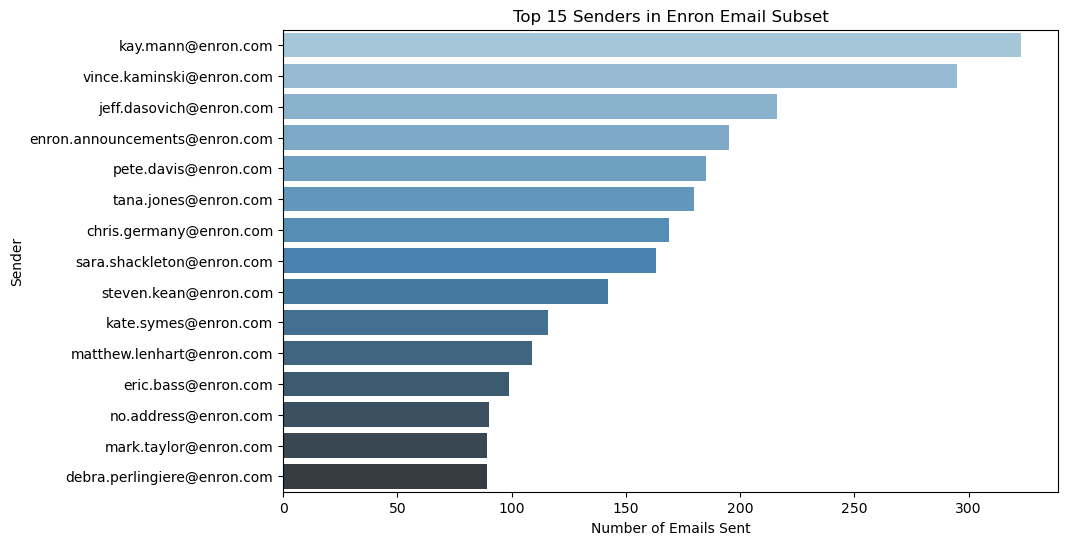

In [11]:
# --- WHO SENDS THE MOST EMAILS ---
top_senders = df['from'].value_counts().head(15)

plt.figure(figsize=(10,6))
sns.barplot(y=top_senders.index, x=top_senders.values, palette='Blues_d')
plt.title('Top 15 Senders in Enron Email Subset')
plt.xlabel('Number of Emails Sent')
plt.ylabel('Sender')
plt.show()

/var/folders/x9/jqqq866x10db2q2p1xb08c540000gn/T/ipykernel_12298/1781059401.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='word', x='count', data=common_words, palette='viridis')


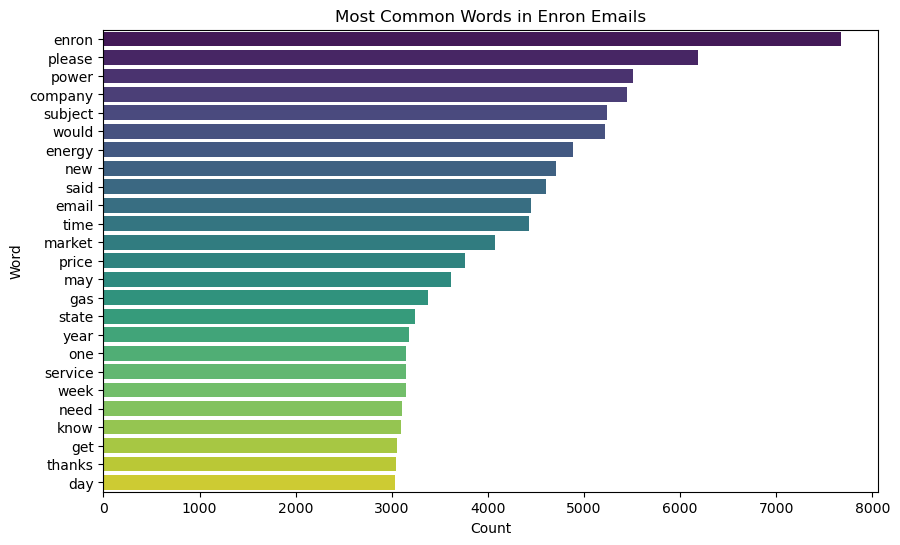

In [13]:
from collections import Counter

# Combine all clean bodies into one text
all_words = ' '.join(df['clean_body']).split()
word_freq = Counter(all_words)

# Get top 25 most common words
common_words = pd.DataFrame(word_freq.most_common(25), columns=['word', 'count'])

plt.figure(figsize=(10,6))
sns.barplot(y='word', x='count', data=common_words, palette='viridis')
plt.title('Most Common Words in Enron Emails')
plt.xlabel('Count')
plt.ylabel('Word')
plt.show()

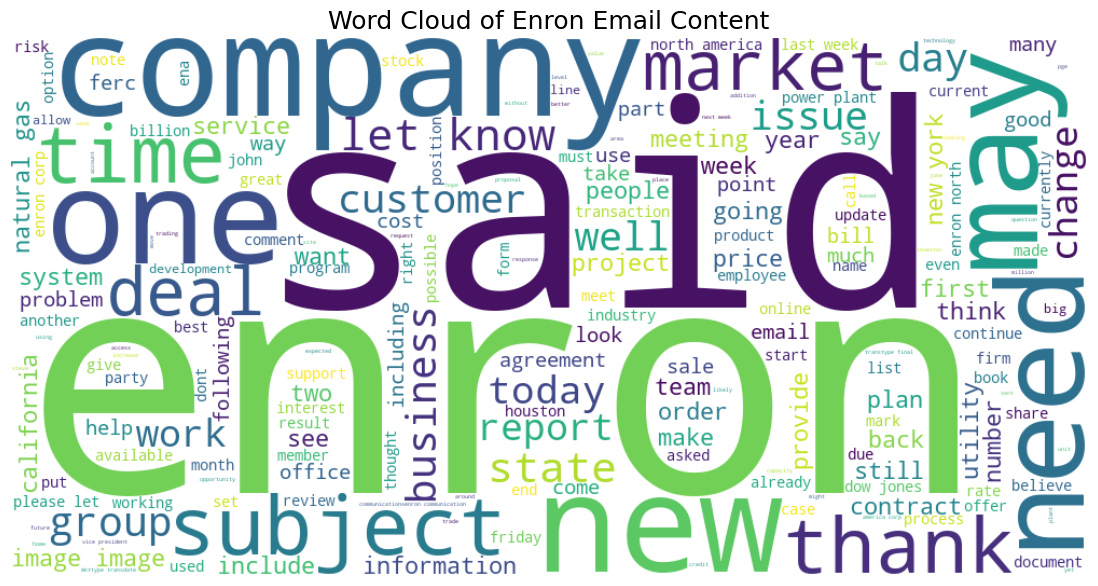

In [15]:
from wordcloud import WordCloud

text = ' '.join(df['clean_body'])
wordcloud = WordCloud(width=1000, height=500, background_color='white').generate(text)

plt.figure(figsize=(15,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Enron Email Content', size=18)
plt.show()

In [23]:
!pip install textblob
!python -m textblob.download_corpora

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 624.3/624.3 kB 1.4 MB/s eta 0:00:00-:--:--
[nltk_data] Downloading package brown to /Users/daniel/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/daniel/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /Users/daniel/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/daniel/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package conll2000 to
[nltk_data]     /Users/daniel/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /Users/daniel/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.


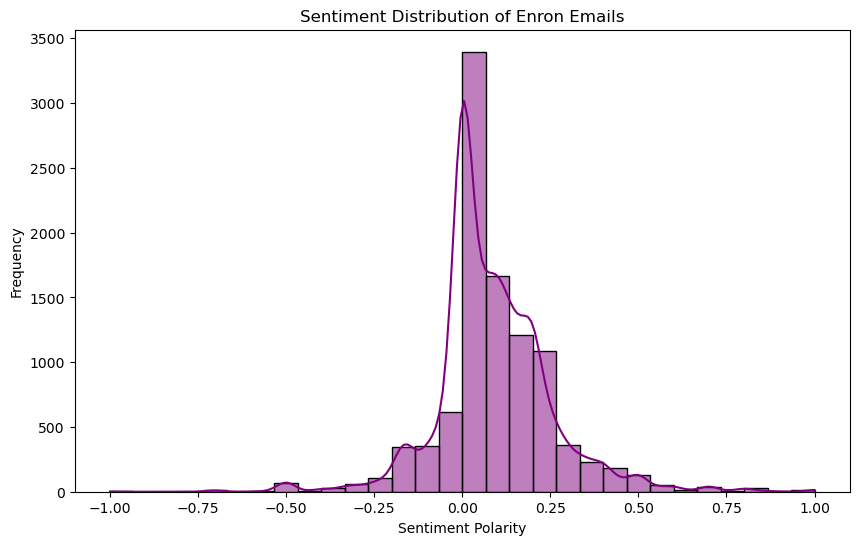

In [25]:
from textblob import TextBlob

df['sentiment'] = df['clean_body'].apply(lambda x: TextBlob(x).sentiment.polarity)

plt.figure(figsize=(10,6))
sns.histplot(df['sentiment'], bins=30, kde=True, color='purple')
plt.title('Sentiment Distribution of Enron Emails')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.show()

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob

# --- Basic numeric features ---
df['body_length'] = df['clean_body'].apply(len)
df['num_recipients'] = df['to'].apply(lambda x: len(str(x).split(',')) if x else 0)
df['sentiment'] = df['clean_body'].apply(lambda x: TextBlob(x).sentiment.polarity)

# --- TF-IDF text features ---
tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
X_text = tfidf.fit_transform(df['clean_body'])

# Combine into one modeling dataset
X = pd.concat([
    pd.DataFrame(X_text.toarray(), columns=tfidf.get_feature_names_out()),
    df[['body_length', 'num_recipients', 'sentiment']].reset_index(drop=True)
], axis=1)

print("Feature matrix shape:", X.shape)
X.head()

Feature matrix shape: (10000, 1003)


,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa,ability,able,access,according,account,accounting,act,action,activity,actually,add,added,addition,additional,address,administration,advise,affiliate,afternoon,agency,agent,ago,agree,agreed,agreement,ahead,air,airline,alignleft,allow,allowed,amendment,america,american,analysis,analyst,andor,angeles,announced,annual,answer,appeal,appears,applicable,application,apply,appreciate,approach,appropriate,approval,approved,approximately,april,area,article,ask,asked,asset,assignment,assistance,associate,associated,attached,attachment,attend,attorney,august,authority,availability,available,average,away,bad,balance,bank,bankruptcy,based,basis,begin,beginning,believe,ben,benefit,best,better,bid,big,billion,blackout,board,bob,bond,book,border,brian,bring,broker,brown,build,building,bush,business,buy,buyer,buying,calendar,california,called,came,canada,candidate,cap,capacity,capital,car,card,carol,case,cash,cell,cent,center,central,ceo,certain,chairman,chance,change,changed,charge,chart,check,chicago,chief,choice,chris,city,claim,class,clear,clearing,click,client,close,closed,coal,code,come,coming,comment,commercial,commission,committee,commodity,communication,communicationsenron,community,company,competition,competitive,complete,completed,computer,concern,condition,conference,confidential,confirm,confirmation,consider,construction,consumer,contact,contained,content,continue,contract,control,copy,copyright,corp,corporate,corporation,correct,cost,counsel,counterparty,country,county,couple,course,court,cover,create,created,credit,crisis,current,currently,customer,cut,daily,dan,data,database,date,dave,david,davis,day,dbcapsdata,deal,dealno,dear,debt,dec,december,decision,delete,delivery,demand,department,deregulation,derivative,description,desk,detected,determine,development,didnt,diego,different,direct,directly,director,discus,discussed,discussion,distribution,district,division,doc,document,doesnt,dollar,dont,dow,draft,drive,duke,dynegy,earlier,early,earnings,east,economic,economy,edison,ee,effect,effective,effort,electric,electricity,electronic,elizabeth,email,emission,employee,ena,end,energy,engy,enron,enrononline,enrons,ensure,enter,entire,entity,environment,environmental,eol,epmi,equipment,equity,eric,error,estimate,europe,european,event,example,exchange,executed,executive,existing,expect,expected,expense,experience,face,facearial,facility,fact,fall,family,fantasy,far,fare,fast,fax,feb,february,federal,fee,feedback,feel,ferc,field,file,filed,filing,final,finance,financial,fine,firm,floor,flow,focus,follow,following,follows,force,form,forward,forwarded,francisco,frank,free,fri,friday,friend,fuel,function,fund,funding,future,fyi,game,gary,gas,general,generation,generator,george,getting,gift,given,global,goal,going,good,got,gov,government,governor,great,greg,grid,group,growth,guarantee,guy,half,hand,happy,hard,havent,head,hear,heard,hearing,height,held,help,high,higher,hit,hold,holding,holiday,home,hope,hotel,hour,hourahead,house,houston,href,idea,ill,image,immediately,impact,important,include,included,includes,including,increase,increased,independent,index,india,individual,industrial,industry,info,information,initial,input,intended,interested,international,internet,interview,investigation,investment,investor,involved,isda,iso,issue,issued,item,ive,james,jan,january,jeff,jeffrey,jim,job,joe,john,johnson,join,jones,judge,july,june,karen,kate,kay,ken,kevin,key,kim,kind,know,language,large,largest,larry,late,later,latest,law,lawyer,lay,lead,leader,leading,leave,led,left,legal,legislation,let,letter,level,life,light,like,likely,limit,limited,linda,line,link,lisa,list,listed,little,llc,load,local,located,location,log,london,long,longer,longterm,look,looking,los,loss,lost,lot,love,low,lower,lunch,mail,maintenance,major,make,making,manage,management,manager,managing,march,mark,market,marketing,mary,master,material,matter,maybe,mean,measure,medium,meet,meeting,megawatt,member,

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score

# --- Creates a simple target: internal (1) vs. external (0) sender ---
df['is_internal'] = df['from'].apply(lambda x: 1 if 'enron.com' in str(x).lower() else 0)
y = df['is_internal']

# --- Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --- Initialize models ---
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=200, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# --- Train and evaluate ---
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    results[name] = f1_score(y_test, preds)

results_df = pd.DataFrame(list(results.items()), columns=['Model', 'F1_Score']).sort_values(by='F1_Score', ascending=False)
print(results_df)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


                 Model  F1_Score
1        Random Forest  0.939306
2    Gradient Boosting  0.937716
0  Logistic Regression  0.932072


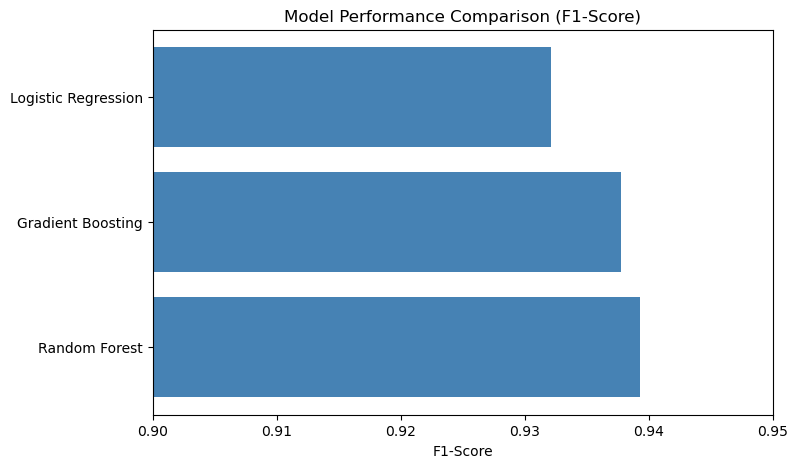

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.barh(results_df['Model'], results_df['F1_Score'], color='steelblue')
plt.title('Model Performance Comparison (F1-Score)')
plt.xlabel('F1-Score')
plt.xlim(0.9, 0.95)
plt.show()

In [33]:
# Reconfirm columns
print(df.columns.tolist())

# Define target (is_internal: 1 if 'enron.com' in sender email, else 0)
df['is_internal'] = df['from'].apply(lambda x: 1 if isinstance(x, str) and 'enron.com' in x.lower() else 0)

# Keep text and target only
X = df['clean_body']
y = df['is_internal']

print("Internal email ratio:")
print(y.value_counts(normalize=True).round(3))

['message_id', 'date', 'from', 'to', 'subject', 'body', 'clean_body', 'sentiment', 'body_length', 'num_recipients', 'is_internal']
Internal email ratio:
is_internal
1    0.833
0    0.167
Name: proportion, dtype: float64


In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print("TF-IDF shape (train):", X_train_tfidf.shape)
print("TF-IDF shape (test):", X_test_tfidf.shape)

TF-IDF shape (train): (8000, 5000)
TF-IDF shape (test): (2000, 5000)


In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
import pandas as pd

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

# Train and evaluate
results = []
for name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    preds = model.predict(X_test_tfidf)
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    results.append({"Model": name, "Accuracy": acc, "F1_Score": f1})

# Show results
results_df = pd.DataFrame(results).sort_values(by="F1_Score", ascending=False)
print(results_df)

                 Model  Accuracy  F1_Score
1        Random Forest    0.9020  0.943968
2    Gradient Boosting    0.8965  0.940942
0  Logistic Regression    0.8900  0.937358


<Figure size 600x500 with 0 Axes>

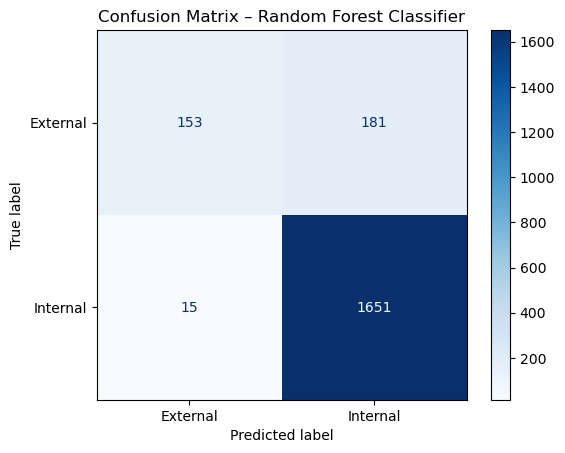

In [39]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Choose best model
best_model = RandomForestClassifier(n_estimators=200, random_state=42)
best_model.fit(X_train_tfidf, y_train)
y_pred = best_model.predict(X_test_tfidf)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["External", "Internal"])

plt.figure(figsize=(6, 5))
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix – Random Forest Classifier")
plt.show()

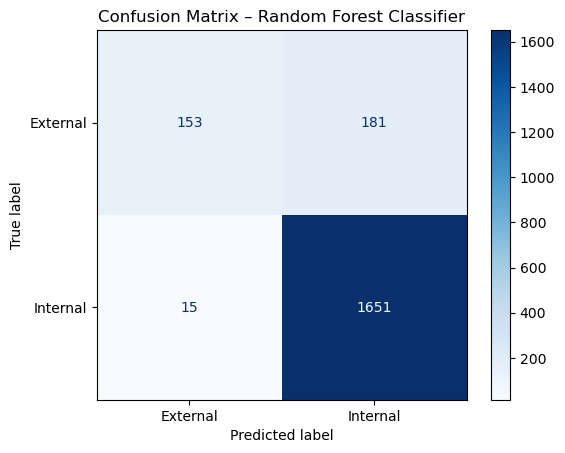

In [41]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["External", "Internal"])

disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix – Random Forest Classifier")
plt.show()

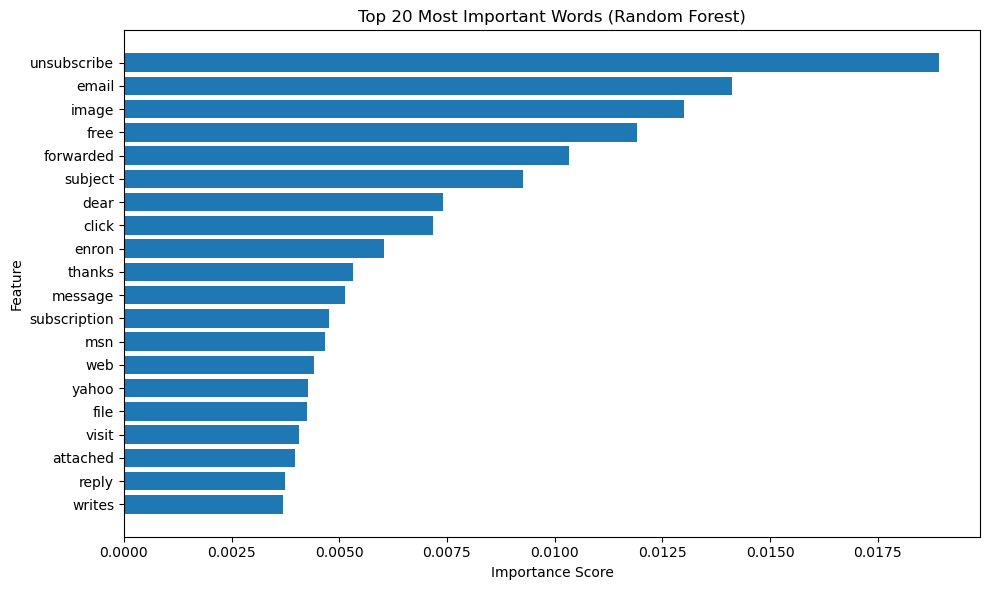

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Get feature importances from the trained Random Forest
importances = best_model.feature_importances_
feature_names = vectorizer.get_feature_names_out()

# Create DataFrame of top 20 important features
feat_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).head(20)

# Plot
plt.figure(figsize=(10,6))
plt.barh(feat_df['Feature'][::-1], feat_df['Importance'][::-1])
plt.title("Top 20 Most Important Words (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [49]:
!pip install -i https://test.pypi.org/simple/ RegularizedRobustRegression==1.1.3

Looking in indexes: https://test.pypi.org/simple/


In [51]:
from RegularizedRobustRegression import bcr

print("Package imported successfully.")

Package imported successfully.


In [53]:
# Convert TF-IDF matrix to a DataFrame (required by bcr)
import pandas as pd

X_train_df = pd.DataFrame(X_train_tfidf.toarray())
y_train_df = pd.Series(y_train.values, name="is_internal")

print("X_train_df shape:", X_train_df.shape)
print("y_train_df shape:", y_train_df.shape)

X_train_df shape: (8000, 5000)
y_train_df shape: (8000,)


In [ ]:
# Run the professor's Regularized Robust Regression (OLS / L2 norm)
results = bcr(
    y_train_df,            # target variable
    X_train_df,            # predictor matrix
    type=2,                # 1 = LAD (L1), 2 = OLS (L2)
    ridge=0.6,             # regularization strength (smaller = stronger regularization)
    niter=20,              # iterations
    n_init=10,             # number of trials
    seed=211171            # random seed
)

# Display key results
print("Regression Type:", results['type'])
print("Regularization Interval:", results['regularization interval'])
print("R-squared:", results['R-square'])
print("Best Trial Number:", results['Best Trial number'])
print("Deviation Accounted For:", results['Deviation Accounted For'])

# Display coefficient summary
coef_names = [f"Feature_{i}" for i in range(X_train_df.shape[1])]
coef_output = pd.DataFrame({'Variable': ['Intercept'] + coef_names, 'Coefficient': results['Beta']})
coef_output.head(10)